In [ ]:
import numpy as np
import pandas as pd

In [ ]:
train = pd.read_csv("train.csv" )
test = pd.read_csv("test_stage1.csv")


In [ ]:
train.iloc[1812:1823]


,ID,comment,label
1812,1813,\nالمغاربة عالم بوحدو أقسم بالله اني اعيش في د...,0
1813,1814,\nالله يرحم ليكم الوالدين .لا تلقحوا أطفالكم ....,0
1814,1815,\nواش مغنسليوش اعباد الله.غير تنقرا خبر ان الت...,0
1815,1816,\nوفي فرنسا كشف المعالجون يوم 25يووليوز، أن جل...,0
1816,1817,\nكلما زاد عدد الملقحين زاد عدد المتوفين والمص...,0
1817,1818,\nياك بعدا تتعتارفو ان الناس مشاو يلقحو بسبب ا...,0
1818,1819,هل تريد تسميم ما تبقا من المواطنين باللقاح الم...,0
1819,1820,انت حر على جسدك ،ومن حقك ان تمتنع عن حقنه بموا...,0
1820,1821,نهار يموت بنادم فالمغرب باللقاح غايقولوا الشع...,0
1821,1822,نحن في حيرة . اللقاح لا يحمي . الكثير أعرض عن ...,0


In [ ]:
train.describe()

,ID,label
count,1920.000000,1920.00000
mean,960.500000,0.50000
std,554.400577,0.50013
min,1.000000,0.00000
25%,480.750000,0.00000
50%,960.500000,0.50000
75%,1440.250000,1.00000
max,1920.000000,1.00000


<Axes: >

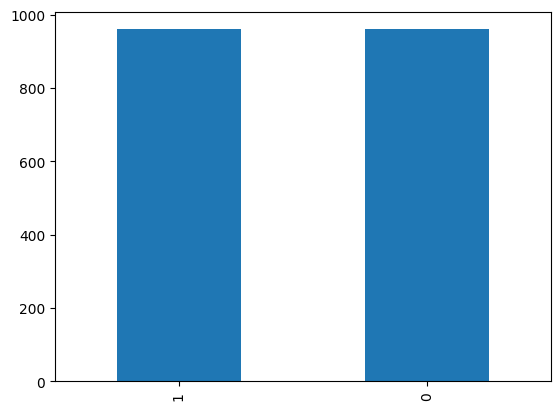

In [ ]:
train['label'].value_counts().plot(kind='bar')

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [ ]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from gensim.models import Word2Vec
from nltk.tokenize import TreebankWordTokenizer
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, recall_score
import joblib
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tqdm import tqdm

In [ ]:
# Charger les données d'entraînement
train_df = pd.read_csv('/content/train.csv')
# Charger les données de test
test_df = pd.read_csv('/content/test_stage1.csv')

In [ ]:
# Extraire les textes et les labels d'entraînement
train_texts, train_labels = train_df['comment'], train_df['label']


In [ ]:
# Tokeniser les textes en utilisant le tokeniseur TreebankWordTokenizer pour l'arabe
tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('arabic'))
stemmer = SnowballStemmer('arabic')

In [ ]:
def preprocess_text(text):
    tokens = tokenizer.tokenize(text)
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words]
    return tokens


In [ ]:
train_texts_tokenized = [preprocess_text(text) for text in train_texts]


In [ ]:
# Ajustement des hyperparamètres Word2Vec
vector_size = 200
window = 8
min_count = 5

# Initialiser un modèle Word2Vec avec les nouveaux hyperparamètres
word2vec_model = Word2Vec(sentences=train_texts_tokenized, vector_size=vector_size, window=window, min_count=min_count, workers=4)

In [ ]:
# Spécifier le nombre d'époques pour l'entraînement
epochs = 20

# Entraîner le modèle Word2Vec sur plusieurs époques
for epoch in range(epochs):
    word2vec_model.train(train_texts_tokenized, total_examples=len(train_texts_tokenized), epochs=1)

In [ ]:
# Fonction pour obtenir les embeddings
def get_embeddings(texts, model):
    embeddings = []
    for text in tqdm(texts):
        valid_words = [word for word in text if word in model.wv]
        embeddings.append(
            sum(model.wv[word] for word in valid_words) / len(valid_words)
            if valid_words
            else [0] * model.vector_size
        )
    return embeddings

In [ ]:
# Obtenir les embeddings pour les données d'entraînement
train_embeddings = get_embeddings(train_texts_tokenized, word2vec_model)

100%|██████████| 1920/1920 [00:00<00:00, 4031.36it/s]


**Classificateur RandomForest**
``````



In [ ]:
random_forest_classifier = RandomForestClassifier(n_estimators=50, random_state=42)


In [ ]:
# Optimiser les hyperparamètres du RandomForest avec GridSearchCV
param_grid = {'n_estimators': [50, 100, 150], 'max_depth': [None, 10, 20]}
grid_search = GridSearchCV(random_forest_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train_embeddings, train_labels)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, random_state=42),
             param_grid={'max_depth': [None, 10, 20],
                         'n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [ ]:
# Enregistrement du meilleur modèle RandomForest
best_random_forest_classifier = grid_search.best_estimator_
joblib.dump(best_random_forest_classifier, 'best_random_forest_model.joblib')

['best_random_forest_model.joblib']

In [ ]:
# Prédire les labels sur l'ensemble d'entraînement avec le modèle RandomForest
predicted_labels_random_forest = best_random_forest_classifier.predict(train_embeddings)

In [ ]:
# Calculer l'accuracy, F1 score et recall sur l'ensemble d'entraînement avec le modèle RandomForest
accuracy_random_forest = accuracy_score(train_labels, predicted_labels_random_forest)
f1_random_forest = f1_score(train_labels, predicted_labels_random_forest, average='weighted')
recall_random_forest = recall_score(train_labels, predicted_labels_random_forest, average='weighted')

print(f'Accuracy  : {accuracy_random_forest * 100:.2f}%')
print(f'Recall : {recall_random_forest:.2f}')
print(f'F1 score : {f1_random_forest:.2f}')

Accuracy  : 99.84%
Recall : 1.00
F1 score : 1.00


In [ ]:
# Obtenir les embeddings pour les données de test
test_texts = test_df['comment']
test_texts_tokenized = [preprocess_text(text) for text in test_texts]
test_embeddings = get_embeddings(test_texts_tokenized, word2vec_model)

# Prédire les labels sur les données de test avec le modèle RandomForest
predictions_random_forest = best_random_forest_classifier.predict(test_embeddings)

# Ajouter les prédictions de RandomForest au DataFrame de test
test_df['predicted_label_random_forest'] = predictions_random_forest

# Enregistrer les prédictions de RandomForest dans un fichier CSV
output_file_path_random_forest_test = 'fichier_random_forest_test.csv'
test_df[['ID', 'predicted_label_random_forest']].to_csv(output_file_path_random_forest_test, index=False)

# Afficher le chemin vers le fichier de sortie
print(f'Les prédictions du modèle RandomForest sur les données de test ont été enregistrées dans : {output_file_path_random_forest_test}')

100%|██████████| 240/240 [00:00<00:00, 12102.30it/s]

Les prédictions du modèle RandomForest sur les données de test ont été enregistrées dans : fichier_random_forest_test.csv


In [ ]:
mytest = pd.read_csv("/content/fichier_random_forest_test.csv" )
mytest[1:6]


,ID,predicted_label_random_forest
1,2,1
2,3,1
3,4,0
4,5,0
5,6,1


In [ ]:
# Test sentence
test_sentence = "لا تلقحوا أطفالكم"

# Tokenize and preprocess the test sentence
tokenized_test_sentence = preprocess_text(test_sentence)

# Get embeddings for the test sentence
test_sentence_embeddings = get_embeddings([tokenized_test_sentence], word2vec_model)

# Predict the label for the test sentence using the RandomForest model
predicted_label_test_sentence = best_random_forest_classifier.predict(test_sentence_embeddings)

# Display the predicted label
print(f'Predicted Label for the Test Sentence: {predicted_label_test_sentence[0]}')


100%|██████████| 1/1 [00:00<00:00, 4088.02it/s]

Predicted Label for the Test Sentence: 0


In [ ]:
# Test sentence
test_sentence = "التلقيح جيد"

# Tokenize and preprocess the test sentence
tokenized_test_sentence = preprocess_text(test_sentence)

# Get embeddings for the test sentence
test_sentence_embeddings = get_embeddings([tokenized_test_sentence], word2vec_model)

# Predict the label for the test sentence using the RandomForest model
predicted_label_test_sentence = best_random_forest_classifier.predict(test_sentence_embeddings)

# Display the predicted label
print(f'Predicted Label for the Test Sentence: {predicted_label_test_sentence[0]}')


100%|██████████| 1/1 [00:00<00:00, 4253.86it/s]

Predicted Label for the Test Sentence: 1
